FIN 513

Group Member:
Sharang Mantri;
Maison Wu;
Nihad Iskandarov

## Question 1a
This code uses the **Leisen–Reimer (LR) binomial model** to price an American put option by building a discrete tree that more closely matches the continuous‐time distribution than standard binomial approaches. It first calculates adjusted probabilities (`hd1`, `hd2`) based on `d1` and `d2`, and then computes up (`u`) and down (`d`) factors for the tree. Next, it builds a lattice of possible stock prices and applies backward induction at each node, taking the maximum of continuation versus immediate exercise. Finally, the value converges to approximately **\$11.02** for the given parameters once a sufficiently large number of time steps is used.


In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import norm

#Leisen & Reimer 1996
#American Put Valuation
#Q1a PS3

def LRAP (S0,K,r,delta,sigma,T,N):

  St = np.zeros([N+1,N+1])
  Dt = T/N
  d1 = (np.log(S0/K) + (r - delta + 0.5*sigma**2)*T) / (sigma * np.sqrt(T))
  d2 =  (np.log(S0/K) + (r - delta - 0.5*sigma**2)*T) / (sigma * np.sqrt(T))

  hd1 = 0.5 + np.sign(d1)*np.sqrt((0.25 - 0.25*np.exp(-(d1/(N+ 1/3))**2 * (N + 1/6))))
  hd2 = 0.5 + np.sign(d2)*np.sqrt((0.25 - 0.25*np.exp(-(d2/(N+ 1/3))**2 * (N + 1/6))))

  u = np.exp((r-delta)*Dt) * hd1 / hd2
  d = (np.exp((r-delta)*Dt) - hd2*u) / (1-hd2)

  def Stock (u,d,Dt):
      St[0,0] = S0
      for i in range (1,N+1):
          St[i, 0] = St[i-1, 0]*d
          for j in range(1, i+1):
              St[i, j] = St[i-1, j-1]*u

  Stock(u,d,Dt)

  V = np.zeros([N+1,N+1])

  i = N
  for j in range(0,i+1):
    V[i,j] = np.maximum((K - St[i,j]) , 0)

  for i in range(N-1,-1,-1):
    for j in range (0, i+1):
      cv = np.exp(-r*Dt) * (hd2 * V[i+1,j+1] + (1-hd2)* V[i+1,j])
      ev = np.maximum(K - St[i,j],0)
      V[i,j] = np.maximum(cv,ev)

  output = {'num_steps': N, 'Value': V[0,0]}

  return output




In [ ]:
value = LRAP(100,105,0.04,0,0.25,1,10001)
value

{'num_steps': 10001, 'Value': 11.020353487795596}

## Q1B Error Calculation for Leisen and Reimer Method
As the number of time steps (N) increases, the binomial approximation becomes finer and the **Leisen–Reimer** price converges toward the benchmark (computed at **N=10001**). Early on, for small N (e.g., 50), the error is more pronounced (often negative, indicating a slight underestimation). As N grows, the error percentage reduces and approaches zero, reflecting that the model is capturing the early‐exercise opportunities more accurately. In other words, the plot clearly shows **convergence**: larger N yields smaller discrepancy compared to the high‐precision benchmark value.


N = 50, Option Price = 10.94815723, Error% = -0.65511744
N = 51, Option Price = 11.01313503, Error% = -0.06550118
N = 52, Option Price = 10.95068381, Error% = -0.63219100
N = 53, Option Price = 11.01305578, Error% = -0.06622023
N = 54, Option Price = 10.95293805, Error% = -0.61173568
N = 55, Option Price = 11.01311617, Error% = -0.06567227
N = 56, Option Price = 10.95513742, Error% = -0.59177835
N = 57, Option Price = 11.01346881, Error% = -0.06247237
N = 58, Option Price = 10.95749497, Error% = -0.57038568
N = 59, Option Price = 11.01397696, Error% = -0.05786135
N = 60, Option Price = 10.95986153, Error% = -0.54891126
N = 61, Option Price = 11.01447318, Error% = -0.05335863
N = 62, Option Price = 10.96206568, Error% = -0.52891047
N = 63, Option Price = 11.01480077, Error% = -0.05038605
N = 64, Option Price = 10.96401137, Error% = -0.51125510
N = 65, Option Price = 11.01492122, Error% = -0.04929307
N = 66, Option Price = 10.96562630, Error% = -0.49660100
N = 67, Option Price = 11.01491

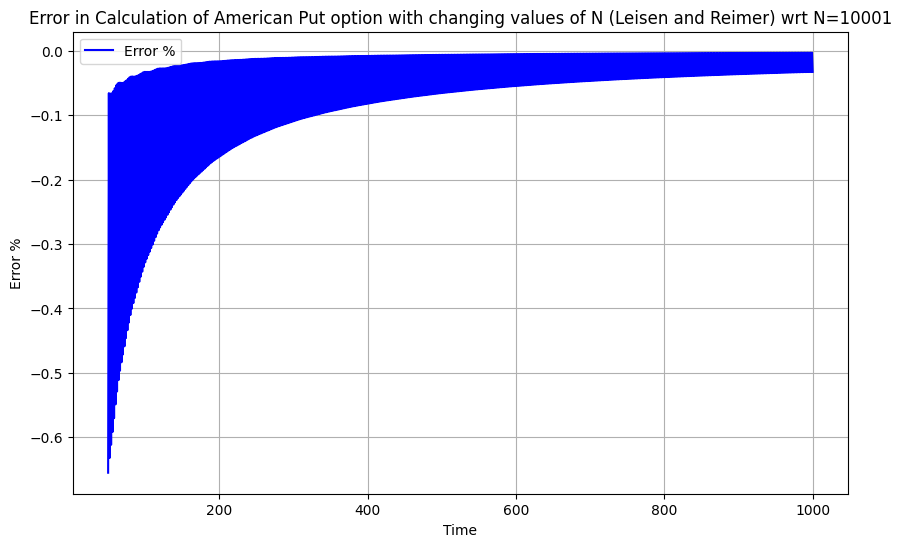

In [ ]:
#Q1B #Error Calculation for Leisen and Reimer Method
N_val = np.arange(50,1001)
Benchmark_val = LRAP(100,105,0.04,0,0.25,1,10001)['Value']
optionval = []
Err_Per = []

for N in N_val:
  putval = LRAP(100,105,0.04,0,0.25,1,N)['Value']
  optionval.append(putval)
  err_per = ((putval - Benchmark_val)/Benchmark_val)*100
  Err_Per.append(err_per)

optionval = np.array(optionval)
Err_Per = np.array(Err_Per)

for i in range(len(N_val)):
  print(f"N = {N_val[i]}, Option Price = {optionval[i]:.8f}, Error% = {Err_Per[i]:.8f}")

plt.figure(figsize=(10,6))
plt.plot(N_val, Err_Per, color='blue', label="Error %")
plt.xlabel("Time")
plt.ylabel("Error %")
plt.title("Error in Calculation of American Put option with changing values of N (Leisen and Reimer) wrt N=10001")
plt.legend()
plt.grid(True)
plt.show()



## Q1B #Error calculation for CRR Method
This code implements the **Cox-Ross-Rubinstein (CRR) binomial model** to price an **American put option**. The CRR model approximates the price of an option by constructing a binomial tree where the stock price moves up or down at each step according to predefined probabilities.

- **CRR is effective but exhibits oscillatory convergence**, unlike the smoother Leisen–Reimer method.
- **More steps (\(N\)) are needed** in CRR to reach the same accuracy as Leisen–Reimer.

In [ ]:


def CRRPUV (S0,K,r,delta,sigma,T,N):       #American Put Option valuation using CRR Binomial Method

  St = np.zeros([N+1,N+1])                #Setting up array for Stock movment
  Dt = T/N                                #delta T
  u = np.exp(sigma * np.sqrt(Dt))
  d = 1/u
  p = (np.exp((r - delta) * Dt) - d) / (u - d)

  def Stock (u,d,Dt):                     #Binomial Stock Tree
      St[0,0] = S0
      for i in range (1,N+1):
          St[i, 0] = St[i-1, 0]*d
          for j in range(1, i+1):
              St[i, j] = St[i-1, j-1]*u

  Stock(u,d,Dt)

  V = np.zeros([N+1,N+1])                 #Option Value Tree

  i = N                                   #Valuation of option at t=T at different values of j
  for j in range(0,i+1):
    V[i,j] = np.maximum((K - St[i,j]) , 0)

  for i in range(N-1,-1,-1):              #Backward Induction in binomial Tree
    for j in range (0, i+1):
      cv = np.exp(-r*Dt) * (p * V[i+1,j+1] + (1-p)* V[i+1,j])
      ev = np.maximum(K - St[i,j],0)
      V[i,j] = np.maximum(cv,ev)

  output = {'num_steps': N, 'Value': V[0,0]}

  return output


N = 50, Option Price = 11.04750799, Error% = 0.24640322
N = 51, Option Price = 11.04160318, Error% = 0.19282220
N = 52, Option Price = 11.04495272, Error% = 0.22321636
N = 53, Option Price = 11.04283951, Error% = 0.20404083
N = 54, Option Price = 11.04243071, Error% = 0.20033132
N = 55, Option Price = 11.04368269, Error% = 0.21169196
N = 56, Option Price = 11.03996539, Error% = 0.17796076
N = 57, Option Price = 11.04433013, Error% = 0.21756693
N = 58, Option Price = 11.03762825, Error% = 0.15675324
N = 59, Option Price = 11.04494165, Error% = 0.22311594
N = 60, Option Price = 11.03546988, Error% = 0.13716797
N = 61, Option Price = 11.04544391, Error% = 0.22767344
N = 62, Option Price = 11.03349878, Error% = 0.11928195
N = 63, Option Price = 11.04586847, Error% = 0.23152595
N = 64, Option Price = 11.03162783, Error% = 0.10230470
N = 65, Option Price = 11.04621093, Error% = 0.23463350
N = 66, Option Price = 11.02981470, Error% = 0.08585219
N = 67, Option Price = 11.04640037, Error% = 0.2

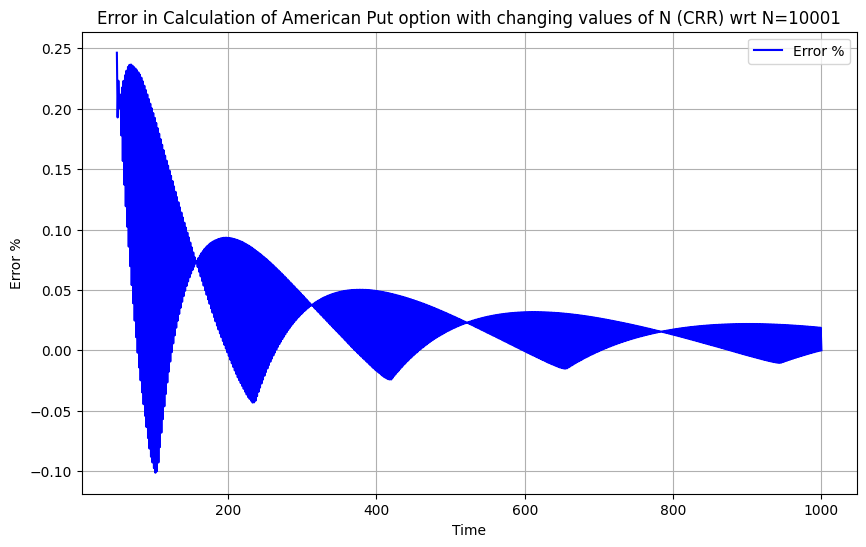

In [ ]:
N_val = np.arange(50,1001)
Benchmark_val = LRAP(100,105,0.04,0,0.25,1,10001)['Value']
optionval = []
Err_Per = []

for N in N_val:
  putval = CRRPUV(100,105,0.04,0,0.25,1,N)['Value']
  optionval.append(putval)
  err_per = ((putval - Benchmark_val)/Benchmark_val)*100
  Err_Per.append(err_per)

optionval = np.array(optionval)
Err_Per = np.array(Err_Per)

for i in range(len(N_val)):
  print(f"N = {N_val[i]}, Option Price = {optionval[i]:.8f}, Error% = {Err_Per[i]:.8f}")

plt.figure(figsize=(10,6))
plt.plot(N_val, Err_Per, color='blue', label="Error %")
plt.xlabel("Time")
plt.ylabel("Error %")
plt.title("Error in Calculation of American Put option with changing values of N (CRR) wrt N=10001")
plt.legend()
plt.grid(True)
plt.show()

## Q1B Error Calculation for Broadie and detemple method
This code implements the **Broadie and Detemple (BDT) method** to price an **American put option**. The Broadie and Detemple method refines the standard binomial approach by incorporating **Black-Scholes-Merton (BSM) approximations** at intermediate steps to improve convergence and accuracy.

- The **Broadie and Detemple method converges more rapidly** compared to traditional binomial models like CRR.
- By incorporating **Black-Scholes adjustments**, this method reduces oscillations and provides **more stable estimates**.


In [ ]:


def BSP(St, K, r, delta, sigma, tau):
    d1 = (np.log(St / K) + (r - delta + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    return (K * np.exp(-r * tau) * norm.cdf(-d2) - St * np.exp(-delta * tau) * norm.cdf(-d1))

def BDT(S0, K, r, delta, sigma, T, N):            #Broadie and Detemple
    St = np.zeros([N+1,N+1])
    Dt = T / N
    u = np.exp(sigma * np.sqrt(Dt))
    d = 1 / u
    q = (np.exp((r - delta) * Dt) - d) / (u - d)

    def Stock (u,d,Dt):                     #Binomial Stock Tree
      St[0,0] = S0
      for i in range (1,N+1):
          St[i, 0] = St[i-1, 0]*d
          for j in range(1, i+1):
              St[i, j] = St[i-1, j-1]*u

    Stock(u,d,Dt)

    V = np.zeros([N+1,N+1])                 #Option Value Tree

    i = N                                   #Valuation of option at t=T at different values of j
    for j in range(0,i+1):
      V[i,j] = np.maximum((K - St[i,j]) , 0)

    i = N-1              #Backward Induction in binomial Tree
    for j in range (0, i+1):
      cv = BSP(St[i,j], K, r, delta, sigma, Dt)
      ev = np.maximum(K - St[i,j],0)
      V[i,j] = np.maximum(cv,ev)

    for i in range(N-2,-1,-1):
      for j in range (0, i+1):
          cv = np.exp(-r * Dt) * (q * V[i+1, j+1] + (1 - q) * V[i+1, j])
          ev = np.maximum(K - St[i, j], 0)
          V[i, j] = np.maximum(cv, ev)

    return V[0, 0]



N = 50, Option Price = 11.03484816, Error% = 0.13421392
N = 51, Option Price = 11.03444217, Error% = 0.13052979
N = 52, Option Price = 11.03438421, Error% = 0.13000383
N = 53, Option Price = 11.03399257, Error% = 0.12644997
N = 54, Option Price = 11.03390328, Error% = 0.12563975
N = 55, Option Price = 11.03341556, Error% = 0.12121400
N = 56, Option Price = 11.03341042, Error% = 0.12116736
N = 57, Option Price = 11.03284646, Error% = 0.11604975
N = 58, Option Price = 11.03293993, Error% = 0.11689789
N = 59, Option Price = 11.03239859, Error% = 0.11198562
N = 60, Option Price = 11.03254122, Error% = 0.11327987
N = 61, Option Price = 11.03206597, Error% = 0.10896728
N = 62, Option Price = 11.03225726, Error% = 0.11070312
N = 63, Option Price = 11.03176895, Error% = 0.10627203
N = 64, Option Price = 11.03199239, Error% = 0.10829958
N = 65, Option Price = 11.03152743, Error% = 0.10408043
N = 66, Option Price = 11.03170926, Error% = 0.10573034
N = 67, Option Price = 11.03126475, Error% = 0.1

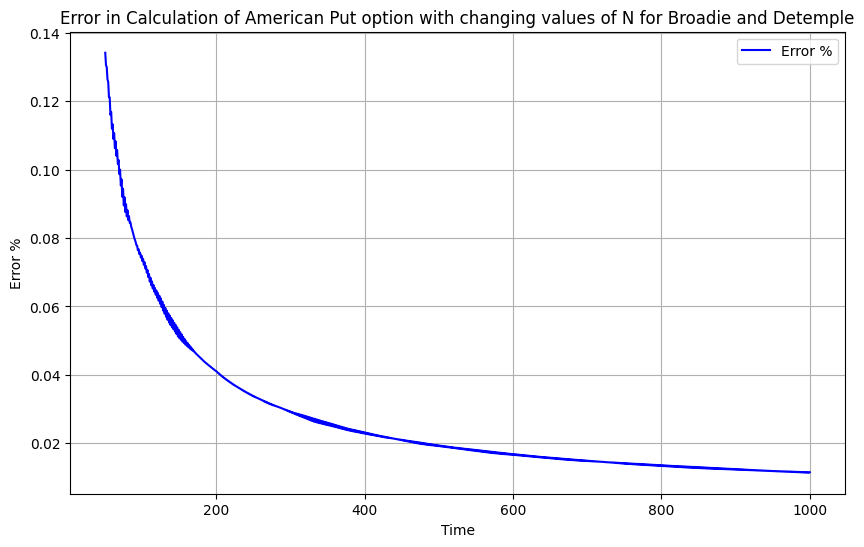

In [ ]:
N_val = np.arange(50,1001)
Benchmark_val = LRAP(100,105,0.04,0,0.25,1,1001)['Value']
optionval = []
Err_Per = []

for N in N_val:
  putval = BDT(100,105,0.04,0,0.25,1,N)
  optionval.append(putval)
  err_per = ((putval - Benchmark_val)/Benchmark_val)*100
  Err_Per.append(err_per)

optionval = np.array(optionval)
Err_Per = np.array(Err_Per)

for i in range(len(N_val)):
  print(f"N = {N_val[i]}, Option Price = {optionval[i]:.8f}, Error% = {Err_Per[i]:.8f}")

plt.figure(figsize=(10,6))
plt.plot(N_val, Err_Per, color='blue', label="Error %")
plt.xlabel("Time")
plt.ylabel("Error %")
plt.title("Error in Calculation of American Put option with changing values of N for Broadie and Detemple")
plt.legend()
plt.grid(True)
plt.show()

## Q1C #Excercise Boundary calculation for CRR Model

This code computes and visualizes the **early exercise boundary** for an **American put option** using the **Cox-Ross-Rubinstein (CRR) binomial model** with **\(N = 100\)**. The **early exercise boundary** represents the stock price level (\( S_f \)) at which the option should be exercised at each point in time.

The x-axis of the plot represents **time** (\(T/N\)), while the y-axis represents the **exercise boundary stock price (\(S_f\))**. The boundary defines the region where **exercise is optimal** (for \( S \leq S_f \)) versus where holding is better (\( S > S_f \)).

- The **early exercise boundary follows expected behavior**, increasing over time.
- **Discrete oscillations** arise due to the binomial approximation.
- **Higher \(N\) reduces these oscillations**, leading to a more accurate boundary and option price.
- **Alternative methods like PDE solvers provide a smoother, more accurate exercise boundary.**


In [ ]:

def CRRPV (S0,K,r,delta,sigma,T,N):       #American Put Option valuation using CRR Binomial Method

  St = np.zeros([N+1,N+1])                #Setting up array for Stock movment
  Dt = T/N                                #delta T
  u = np.exp(sigma * np.sqrt(Dt))
  d = 1/u
  p = (np.exp((r - delta) * Dt) - d) / (u - d)

  def Stock (u,d,Dt):                     #Binomial Stock Tree
      St[0,0] = S0
      for i in range (1,N+1):
          St[i, 0] = St[i-1, 0]*d
          for j in range(1, i+1):
              St[i, j] = St[i-1, j-1]*u

  Stock(u,d,Dt)

  V = np.zeros([N+1,N+1])                 #Option Value Tree
  Er_Ex_Bou = []                          #Exercise Boundary Level Creation

  i = N                                   #Valuation of option at t=T at different values of j
  for j in range(0,i+1):
    V[i,j] = np.maximum((K - St[i,j]) , 0)

  for i in range(N-1,-1,-1):              #Backward Induction in binomial Tree
    Ex_Bou = None
    for j in range (0, i+1):
      cv = np.exp(-r*Dt) * (p * V[i+1,j+1] + (1-p)* V[i+1,j])
      ev = np.maximum(K - St[i,j],0)
      V[i,j] = np.maximum(cv,ev)
      if ev > cv:      #Checking for exercise boundary level
        Ex_Bou = St[i,j]
    if Ex_Bou:
      Er_Ex_Bou.append((i,Ex_Bou))

  Er_Ex_Bou = np.array(Er_Ex_Bou)


  plt.figure(figsize=(10,6))
  plt.plot(Er_Ex_Bou[:,0]/100, Er_Ex_Bou[:,1], 'blue', label="Early Exercise Boundary")
  plt.xlabel("Time T/N")
  plt.ylabel("Stock Price (St)")
  plt.title("Early Exercise Boundary for American Put (CRR Model)")
  plt.legend()
  plt.grid(True)
  plt.show()

  return(Er_Ex_Bou)




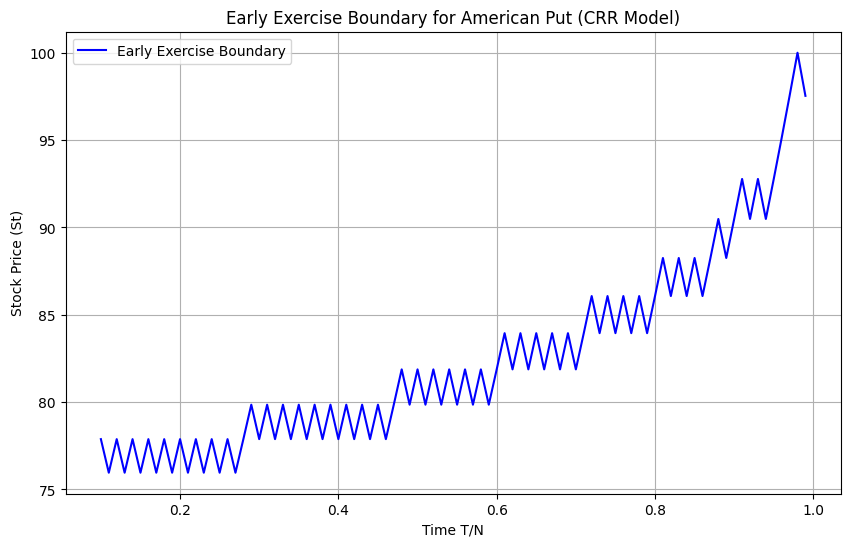

array([[ 99.        ,  97.5309912 ],
       [ 98.        , 100.        ],
       [ 97.        ,  97.5309912 ],
       [ 96.        ,  95.12294245],
       [ 95.        ,  92.77434863],
       [ 94.        ,  90.4837418 ],
       [ 93.        ,  92.77434863],
       [ 92.        ,  90.4837418 ],
       [ 91.        ,  92.77434863],
       [ 90.        ,  90.4837418 ],
       [ 89.        ,  88.24969026],
       [ 88.        ,  90.4837418 ],
       [ 87.        ,  88.24969026],
       [ 86.        ,  86.07079764],
       [ 85.        ,  88.24969026],
       [ 84.        ,  86.07079764],
       [ 83.        ,  88.24969026],
       [ 82.        ,  86.07079764],
       [ 81.        ,  88.24969026],
       [ 80.        ,  86.07079764],
       [ 79.        ,  83.94570208],
       [ 78.        ,  86.07079764],
       [ 77.        ,  83.94570208],
       [ 76.        ,  86.07079764],
       [ 75.        ,  83.94570208],
       [ 74.        ,  86.07079764],
       [ 73.        ,  83.94570208],
 

In [ ]:
CRRPV(100,105,0.04,0,0.25,1,100)

## Q2

This code implements the **Leisen & Reimer (1996) binomial model** to price a **down-and-out call option**, which is a barrier option that expires worthless if the stock price falls below a certain barrier \( B \) before maturity. The calculated option values are compared against the **analytical solution**, and the **error percentage** is plotted against time steps \( N \).

Additionally, the **lambda function** (which measures the position of nodes relative to the barrier) is computed and plotted alongside the error profile.
- The **error percentage decreases as \( N \) increases**, confirming that the Leisen & Reimer method **converges** toward the analytical price.
- The **oscillatory pattern** arises due to the discrete placement of stock price nodes relative to the barrier.
- The **red lambda curve** shows how node positions relative to the barrier fluctuate.
- **Spikes in error correspond to cases where nodes are poorly aligned with the barrier**, reinforcing the importance of node placement in binomial pricing.


## Conclusion

- The **Leisen & Reimer method provides accurate pricing** for barrier options, but its convergence is influenced by the **discrete placement of nodes relative to the barrier**.
- The **oscillatory error profile** suggests that barrier misalignment impacts pricing accuracy.
- **Higher \(N\) values lead to smoother convergence**, improving the precision of the computed option values.
- **Future improvements** could include adjusting node placements or using alternative methods (e.g., trinomial trees or Monte Carlo simulations) for better barrier approximation.

In [ ]:


def CBCO(S0,K,B,r,delta,sigma,T,N):               #Continuous Barrier Down-and-out call Option using Leisen and Reimer Method

  St = np.zeros([N+1,N+1])                        #Setting up array for Stock movment
  Dt = T/N                                        #Delta T
  d1 = (np.log(S0/K) + (r - delta + 0.5*sigma**2)*T) / (sigma * np.sqrt(T))
  d2 =  (np.log(S0/K) + (r - delta - 0.5*sigma**2)*T) / (sigma * np.sqrt(T))

  hd1 = 0.5 + np.sign(d1)*np.sqrt((0.25 - 0.25*np.exp(-(d1/(N+ 1/3))**2 * (N + 1/6))))
  hd2 = 0.5 + np.sign(d2)*np.sqrt((0.25 - 0.25*np.exp(-(d2/(N+ 1/3))**2 * (N + 1/6))))

  u = np.exp((r-delta)*Dt) * hd1 / hd2
  d = (np.exp((r-delta)*Dt) - hd2*u) / (1-hd2)

  def Stock (u,d,Dt):                             #Binomial Stock Tree
      St[0,0] = S0
      for i in range (1,N+1):
          St[i, 0] = St[i-1, 0]*d
          for j in range(1, i+1):
              St[i, j] = St[i-1, j-1]*u

  Stock(u,d,Dt)

  def lambda_func(B,St): #Renamed function to avoid keyword conflict
    Fi_Pr = St[-1,:]
    Fi_Pr = np.sort(Fi_Pr)

    idx = np.searchsorted(Fi_Pr,B)

    Sk = Fi_Pr[idx]
    Sk_1 = Fi_Pr[idx-1]

    lamb = (Sk - B)/(Sk - Sk_1)

    return(lamb)

  lambd = lambda_func(B,St)

  V = np.zeros([N+1,N+1])

  i = N                                         #Value of Call option at Time t=T for different j
  for j in range(0,i+1):
    V[i,j] = np.maximum((St[i,j]-K)  , 0)

  for i in range(N-1,-1,-1):                    #Backward Induction in binomial Tree
    for j in range (0, i+1):
      cv = np.exp(-r*Dt) * (hd2 * V[i+1,j+1] + (1-hd2)* V[i+1,j])
      ev =np.maximum( St[i,j] - K,0)
      V[i,j] = np.maximum(cv,ev)
      if St[i,j] < B: V[i,j] = 0                #Checking Barrier Conditions

  output = {'num_steps': N, 'Value': V[0,0], 'lambda':lambd}

  return output





N = 51, Option Price = 4.63966089, Error% = 5.50672405, Lambda = 0.87887927
N = 53, Option Price = 4.58925116, Error% = 4.36039776, Lambda = 0.90475452
N = 55, Option Price = 4.54053484, Error% = 3.25257975, Lambda = 0.93014486
N = 57, Option Price = 4.49342213, Error% = 2.18122839, Lambda = 0.95507656
N = 59, Option Price = 4.44782917, Error% = 1.14443614, Lambda = 0.97957361
N = 61, Option Price = 4.64049758, Error% = 5.52575058, Lambda = 0.00378532
N = 63, Option Price = 5.10474764, Error% = 16.08288040, Lambda = 0.02828656
N = 65, Option Price = 5.06653652, Error% = 15.21395275, Lambda = 0.05237597
N = 67, Option Price = 5.02916590, Error% = 14.36413798, Lambda = 0.07607358
N = 69, Option Price = 4.99261141, Error% = 13.53288247, Lambda = 0.09939785
N = 71, Option Price = 4.95684892, Error% = 12.71963698, Lambda = 0.12236582
N = 73, Option Price = 4.92185461, Error% = 11.92385993, Lambda = 0.14499331
N = 75, Option Price = 4.88760509, Error% = 11.14501988, Lambda = 0.16729498
N = 7

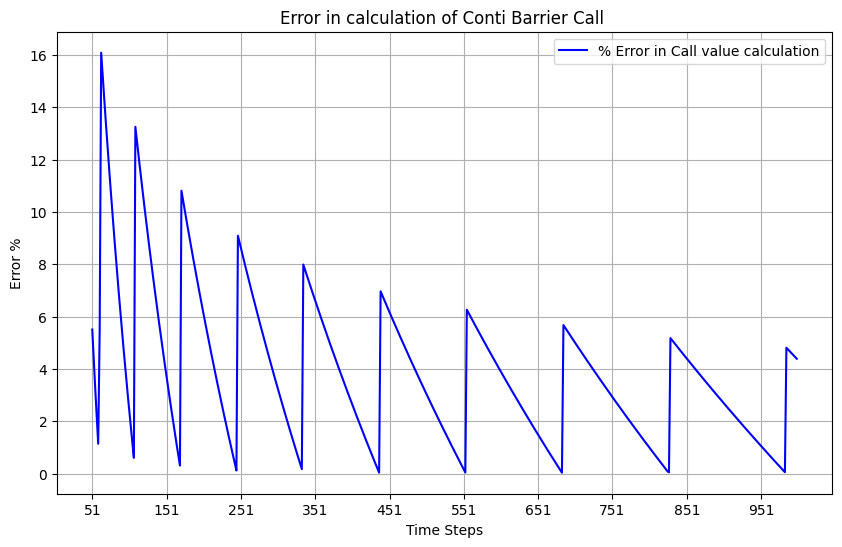

<Figure size 1000x600 with 0 Axes>

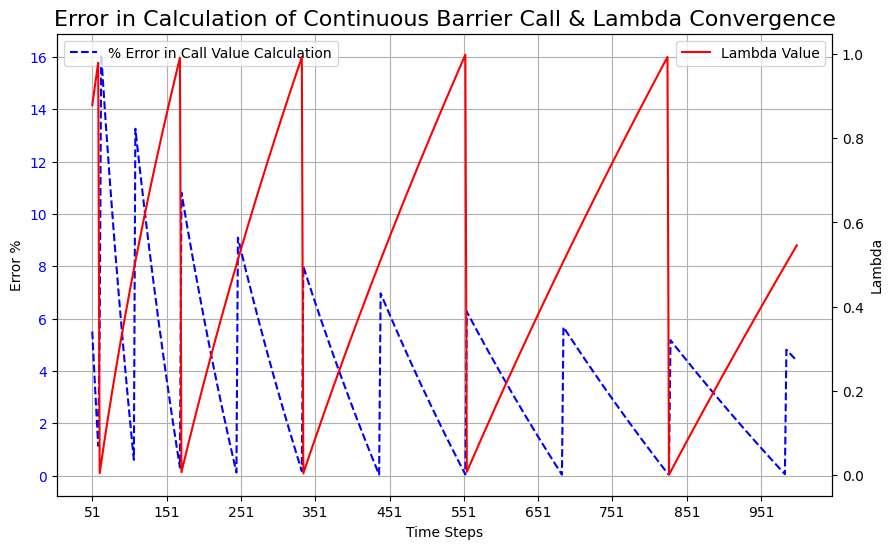

In [ ]:
def Analytical_val (S0,K,B,r,delta,sigma,T):
    d1 = (np.log(S0 / K) + (r - delta + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    h1 = (np.log(B**2/(K*S0))+ (r - delta + 0.5*sigma**2)*T)/(sigma* np.sqrt(T))
    h2 = (np.log(B**2/(K*S0))+ (r - delta - 0.5*sigma**2)*T)/(sigma* np.sqrt(T))

    Call_Val = S0 * np.exp(-delta*T) * norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2) - (B/S0)**(1+2*r*sigma**(-2)) * S0 *norm.cdf(h1) + (B/S0)**(-1+2*r*sigma**(-2))*K*np.exp(-r*T)*norm.cdf(h2)

    return(Call_Val)


N_val = np.arange(51,1000,2)
Benchmark = Analytical_val(100,100,95,0.1,0,0.3,0.2)
Call_Value = []
Err_Per = []
lambda_val = []


for N in N_val:
  opt_val = CBCO(100,100,95,0.1,0,0.3,0.2,N)['Value']
  lambda_val.append(CBCO(100,100,95,0.1,0,0.3,0.2,N)['lambda'])
  Call_Value.append(opt_val)
  err_per = ((opt_val - Benchmark)/Benchmark)*100
  Err_Per.append(err_per)

Err_Per = np.array(Err_Per)
Call_Value = np.array(Call_Value)
lambda_val = np.array(lambda_val)


for i in range(len(N_val)):
  print(f"N = {N_val[i]}, Option Price = {Call_Value[i]:.8f}, Error% = {Err_Per[i]:.8f}, Lambda = {lambda_val[i]:.8f}")

plt.figure(figsize=(10,6))
plt.plot(N_val, Err_Per, color='blue', label="% Error in Call value calculation")
plt.xlabel("Time Steps")
plt.ylabel("Error %")
plt.title("Error in calculation of Conti Barrier Call ")
plt.xticks(np.arange(min(N_val), max(N_val)+50, 100))
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10,6))
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(N_val, Err_Per, 'b--', label="% Error in Call Value Calculation")  # Dotted blue line
ax1.set_xlabel("Time Steps")
ax1.set_ylabel("Error %")
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(N_val, lambda_val, 'red', label="Lambda Value")  # Solid red line
ax2.set_ylabel("Lambda")
ax2.tick_params(axis='y')
plt.title("Error in Calculation of Continuous Barrier Call & Lambda Convergence", fontsize=16)
ax1.grid()
plt.xticks(np.arange(min(N_val), max(N_val) + 50, 100))
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.show()


## Q3

Observations from the Graphs

### **Error vs. Time Steps**
- The error **oscillates** as \( N \) increases.
- The **zigzag pattern** indicates that certain tree structures align better with the barrier than others.
- The **error remains relatively small**, suggesting good accuracy for high \( N \).

### **Error and Lambda Convergence**
- The **red lambda curve** tracks the position of the closest stock price node to the barrier.
- **Spikes in error correspond to cases where nodes are poorly aligned with the barrier**.
- **The most accurate option values occur when lambda is near 0.5**, meaning the barrier is well-represented within the tree.

## Conclusion

- **The Leisen & Reimer model performs well** for discrete barrier options, but accuracy depends on **how well the tree aligns with the barrier dates**.
- **Oscillations in error arise from discretization effects** in the tree structure.
- **Higher \(N\) values improve accuracy**, but optimal performance is achieved when **lambda values are well-balanced (near 0.5)**.
- Future improvements could involve **adaptive time-stepping** or **higher-order interpolation methods** to refine the barrier representation in the binomial tree.

In [ ]:

def DBCO(S0,K,B,r,delta,sigma,T,N):             #Discrete Barrier Down-and-out Call Option Valuation
  ND = 4                                        #ND = Number of Barrier dayes
  TD = np.zeros([ND])                           #creates an array with 4 entries
  TD = [0.04,0.08,0.12,0.16]                    #TD = array of barrier Dates

  St = np.zeros([N+1,N+1])
  Dt = T/N
  d1 = (np.log(S0/K) + (r - delta + 0.5*sigma**2)*T) / (sigma * np.sqrt(T))
  d2 =  (np.log(S0/K) + (r - delta - 0.5*sigma**2)*T) / (sigma * np.sqrt(T))
  iD1 = [i/Dt for i in TD]
  iD = [np.ceil(i) for i in iD1]

  hd1 = 0.5 + np.sign(d1)*np.sqrt((0.25 - 0.25*np.exp(-(d1/(N+ 1/3))**2 * (N + 1/6))))
  hd2 = 0.5 + np.sign(d2)*np.sqrt((0.25 - 0.25*np.exp(-(d2/(N+ 1/3))**2 * (N + 1/6))))

  u = np.exp((r-delta)*Dt) * hd1 / hd2
  d = (np.exp((r-delta)*Dt) - hd2*u) / (1-hd2)

  def Stock (u,d,Dt):                             #Binomial Stock Tree
      St[0,0] = S0
      for i in range (1,N+1):
          St[i, 0] = St[i-1, 0]*d
          for j in range(1, i+1):
              St[i, j] = St[i-1, j-1]*u

  Stock(u,d,Dt)

  def lambda_func(B,St): #Renamed function to avoid keyword conflict
    Fi_Pr = St[-1,:]
    Fi_Pr = np.sort(Fi_Pr)

    idx = np.searchsorted(Fi_Pr,B)

    Sk = Fi_Pr[idx]
    Sk_1 = Fi_Pr[idx-1]

    lamb = (Sk - B)/(Sk - Sk_1)

    return(lamb)

  lambd = lambda_func(B,St)

  V = np.zeros([N+1,N+1])

  i = N                                           #Option Valuation at t=T for different j
  for j in range(0,i+1):
    V[i,j] = np.maximum((St[i,j]-K)  , 0)

  for i in range(N-1,-1,-1):                      #Backward induction
    for j in range (0, i+1):
      cv = np.exp(-r*Dt) * (hd2 * V[i+1,j+1] + (1-hd2)* V[i+1,j])
      ev = np.maximum(St[i,j] - K,0)
      V[i,j] = np.maximum(cv,ev)
      if i in iD:                               #Cheking Barrier Condition
        if St[i,j] < B: V[i,j] = 0


  output = {'num_steps': N, 'Value': V[0,0], 'Lambda':lambd}

  return output


N = 50, Option Price = 5.76387949, Error% = 1.63591317, Lambda = 0.36791223
N = 60, Option Price = 5.67831648, Error% = 0.12715939, Lambda = 0.49583357
N = 70, Option Price = 5.60387738, Error% = -1.18544359, Lambda = 0.61316177
N = 80, Option Price = 5.53869437, Error% = -2.33483179, Lambda = 0.72215860
N = 90, Option Price = 5.48115394, Error% = -3.34945643, Lambda = 0.82438030
N = 100, Option Price = 5.42994857, Error% = -4.25237333, Lambda = 0.92095181
N = 110, Option Price = 5.87973411, Error% = 3.67880629, Lambda = 0.01304637
N = 120, Option Price = 5.84003376, Error% = 2.97876021, Lambda = 0.10281334
N = 130, Option Price = 5.80256008, Error% = 2.31797753, Lambda = 0.18868866
N = 140, Option Price = 5.76718927, Error% = 1.69427535, Lambda = 0.27113739
N = 150, Option Price = 5.73378346, Error% = 1.10522238, Lambda = 0.35053891
N = 160, Option Price = 5.70220284, Error% = 0.54835363, Lambda = 0.42720746
N = 170, Option Price = 5.67231216, Error% = 0.02128387, Lambda = 0.50140681


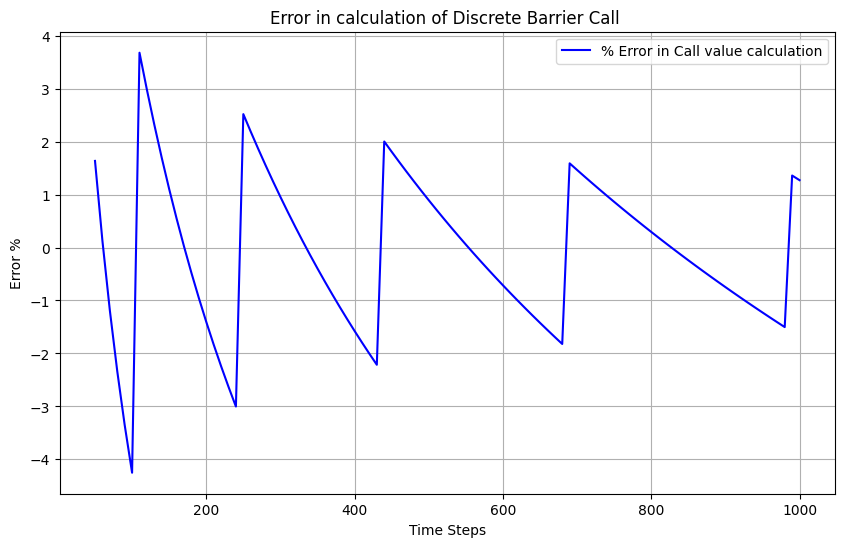

<Figure size 1000x600 with 0 Axes>

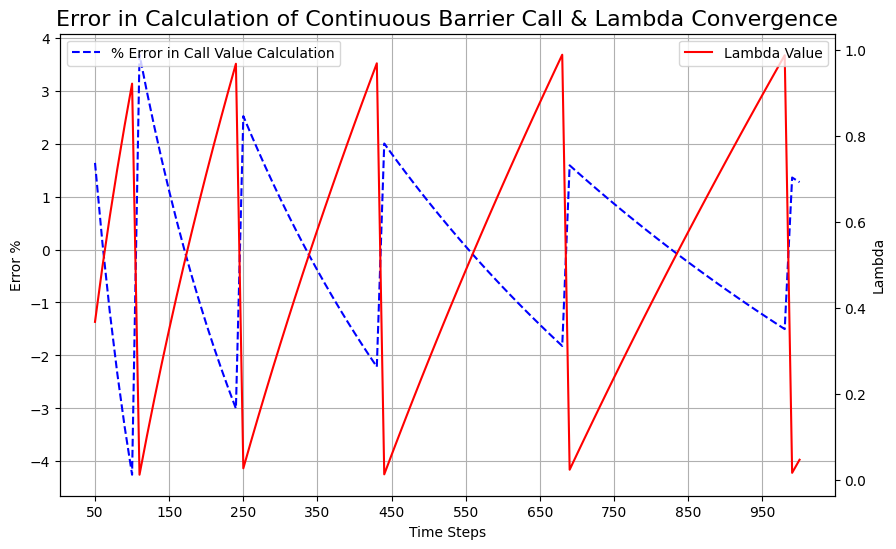

In [ ]:
N_val = np.arange(50,1001,10)
benchmark = 5.6711051343
Call_Val =[]
Err_Per = []
lambda_val = []

for N in N_val:
  opt_val = DBCO(100,100,95,0.1,0,0.3,0.2,N)['Value']
  lambda_val.append(DBCO(100,100,95,0.1,0,0.3,0.2,N)['Lambda'])
  Call_Val.append(opt_val)
  err_per = ((opt_val - benchmark)/benchmark)*100
  Err_Per.append(err_per)

Call_Val = np.array(Call_Val)
Err_Per = np.array(Err_Per)
lambda_val = np.array(lambda_val)

for i in range(len(N_val)):
  print(f"N = {N_val[i]}, Option Price = {Call_Val[i]:.8f}, Error% = {Err_Per[i]:.8f}, Lambda = {lambda_val[i]:.8f}")

plt.figure(figsize=(10,6))
plt.plot(N_val, Err_Per, color='blue', label="% Error in Call value calculation")
plt.xlabel("Time Steps")
plt.ylabel("Error %")
plt.title("Error in calculation of Discrete Barrier Call ")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10,6))
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(N_val, Err_Per, 'b--', label="% Error in Call Value Calculation")  # Dotted blue line
ax1.set_xlabel("Time Steps")
ax1.set_ylabel("Error %")
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
ax2.plot(N_val, lambda_val, 'r-', label="Lambda Value")  # Solid red line
ax2.set_ylabel("Lambda")
ax2.tick_params(axis='y')
plt.title("Error in Calculation of Discrete Barrier Call & Lambda Convergence", fontsize=16)
ax1.grid()
plt.xticks(np.arange(min(N_val), max(N_val) + 50, 100))
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.show()